In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(r'Z:\Therm_Evo_Analysis_Oliver\Data analysis\Data analysis 2024 campaign\IGOR_exported\try\20241211_135846_D-raffinose_0.15umol_p.csv', sep=',')
print(df.columns[:20])

Index(['time', '18.981290', 'H3O+', '20.022371', '21.022209', '27.022605',
       '27.909088', '28.030834', '29.002270', 'C2H5+', 'NO+', 'CH3O+',
       '31.024425', 'O2+', 'CH5O+', '33.982169', '33.992191', '34.028820',
       'Cl', '35.025796'],
      dtype='object')


Total de datos procesados: 1748
Datos en rango 40-200 m/z: 1264
Umbral de intensidad: 1.11e-02
Encontrados 26 picos significativos

Top 15 picos más intensos:
Etiqueta		m/z		Intensidad
--------------------------------------------------
C2H3O+		42.9662	9.80e-02
C2H5O+		44.9788	7.06e-02
C5H5O+		81.0000	5.58e-02
CF3+		68.0573	5.24e-02
C6H7O+		94.0727	3.83e-02
C2H5O2+		60.0332	3.32e-02
44.98		44.9788	2.89e-02
C6H5O2+		108.9892	2.85e-02
C3F5+		130.0728	2.75e-02
C6H5+		76.0592	2.70e-02
(H2O)2H3O+		54.0688	2.49e-02
C5H5O2+		94.0727	2.32e-02
C6H7O2+		108.9892	2.23e-02
C4H5+		53.0138	2.20e-02
C3H7O+		58.9950	2.17e-02


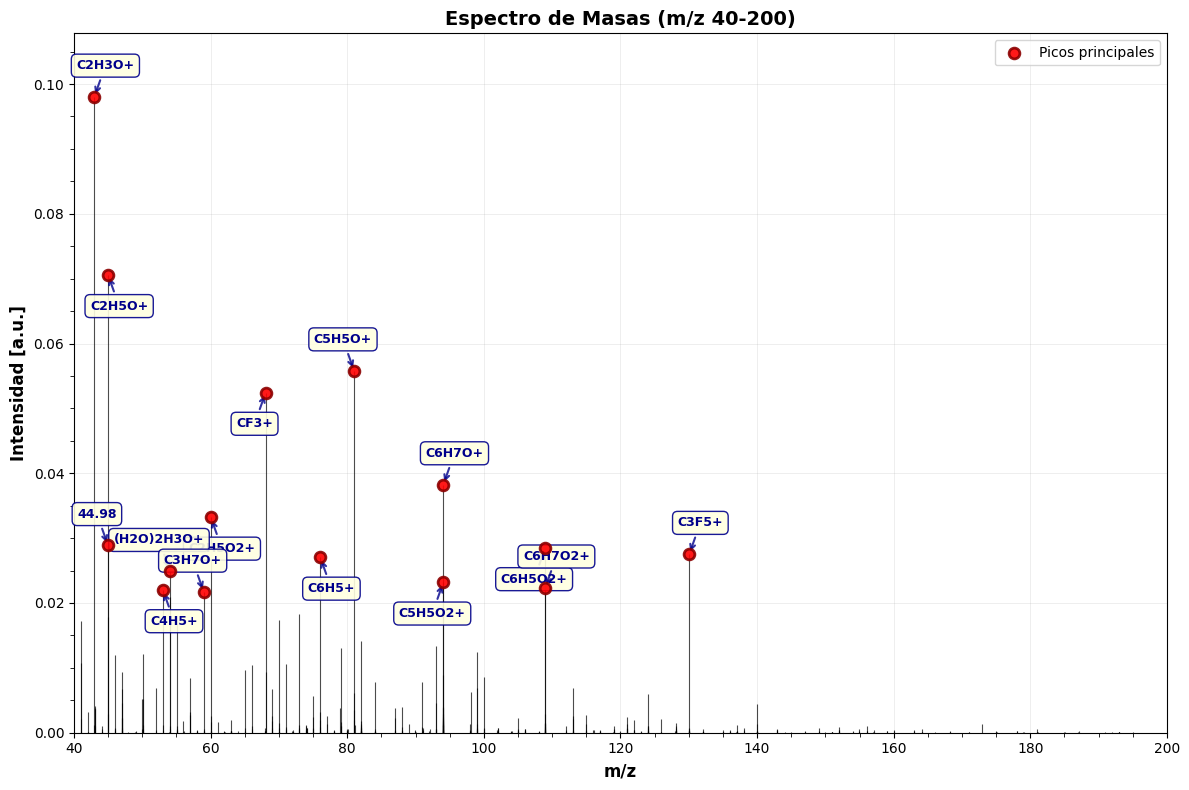


Rango de masa: 40.026 - 199.923
Número de puntos de datos: 1264
Intensidad máxima: 9.80e-02
Intensidad media: 2.24e-03


In [4]:
# Si las columnas están concatenadas en una sola cadena, dividirlas:
#if len(df.columns) == 1:
    # Separar la primera fila que contiene los nombres de columnas
 #   header = df.columns[0].split(',')
    # Cargar nuevamente el archivo con el separador correcto
  #  print("Las columnas parecen estar concatenadas. Usa: df = pd.read_csv('archivo.csv', sep=',')")
    # Por ahora, continuamos asumiendo que df ya está correctamente cargado

# Copy dataframe to avoid overwriting

def masspec(df, time=None):

    """
    parameters

    df = dataframe. Data intensities merged with temperature
    time = intervale time where I want to plot my mass spectrum

------ 

return : masspec_time = plot for the masspectrum
    """
    
    df = merged_df_hr_temp.copy()

    # Determine time column
    if 'Absolute time' in df.columns:
        time_col = 'Absolute time'
    elif 'time' in df.columns:
        time_col = 'time'
    else:
        print("⚠️ Error: No time column found")
        return

    
    


# Extraer la primera fila (time = 0) para el espectro
spectrum_data = df.iloc[0]

# Obtener los nombres de las columnas
columns = df.columns.tolist()

# Procesar columnas y construir datos
filtered_data = []
current_mass = None

for i, col in enumerate(columns):
    col_str = str(col).strip()
    
    # Saltar la columna 'time'
    if col_str.lower() == 'time':
        continue
    
    # Detener cuando llegamos a 'nominal' o 'Total ion current'
    if 'nominal' in col_str.lower() or 'total ion current' in col_str.lower():
        break
    
    # Intentar convertir a float (es un valor m/z)
    try:
        mass = float(col_str)
        current_mass = mass
        intensity = float(spectrum_data.iloc[i])
        
        filtered_data.append({
            'mass': current_mass,
            'intensity': intensity,
            'label': f"{mass:.2f}"
        })
        
    except ValueError:
        # Es una etiqueta de ion (como H3O+, NO+, etc.)
        if current_mass is not None:
            intensity = float(spectrum_data.iloc[i])
            
            filtered_data.append({
                'mass': current_mass,
                'intensity': intensity,
                'label': col_str
            })

# Verificar que tenemos datos
if not filtered_data:
    raise ValueError("No se encontraron datos válidos. Verifica que el DataFrame esté correctamente cargado.")

print(f"Total de datos procesados: {len(filtered_data)}")

# Extraer arrays
x_all = np.array([d['mass'] for d in filtered_data])
y_all = np.array([d['intensity'] for d in filtered_data])
labels_all = np.array([d['label'] for d in filtered_data])

# Filtrar al rango de masa 40-200
mask = (x_all >= 40) & (x_all <= 200)
x_filtered = x_all[mask]
y_filtered = y_all[mask]
labels_filtered = labels_all[mask]

print(f"Datos en rango 40-200 m/z: {len(x_filtered)}")

# Crear el gráfico
plt.figure(figsize=(12, 8))

# Plot del espectro como líneas verticales
plt.vlines(x_filtered, 0, y_filtered, colors='black', linewidth=0.8, alpha=0.7)

# Añadir línea base
plt.axhline(y=0, color='black', linewidth=0.5)

# Identificar picos significativos usando solo valores > 0
y_nonzero = y_filtered[y_filtered > 0]

if len(y_nonzero) > 0:
    # Usar percentil 95 de valores no-cero
    intensity_threshold = np.percentile(y_nonzero, 95)
    
    print(f"Umbral de intensidad: {intensity_threshold:.2e}")
    
    # Encontrar picos significativos con etiquetas químicas (no numéricas)
    significant_peaks = []
    for mass, intensity, label in zip(x_filtered, y_filtered, labels_filtered):
        if intensity > intensity_threshold:
            # Preferir etiquetas químicas sobre valores numéricos
            try:
                float(label)
                # Es un número, solo agregar si no hay mejor opción
                if intensity > intensity_threshold * 1.5:  # Solo picos muy altos
                    significant_peaks.append((mass, intensity, label))
            except ValueError:
                # Es una etiqueta química, agregarla
                significant_peaks.append((mass, intensity, label))
    
    print(f"Encontrados {len(significant_peaks)} picos significativos")
    
    if significant_peaks:
        # Limitar a los top 15 picos más intensos para evitar solapamiento
        significant_peaks = sorted(significant_peaks, key=lambda x: x[1], reverse=True)[:15]
        
        sig_masses = [peak[0] for peak in significant_peaks]
        sig_intensities = [peak[1] for peak in significant_peaks]
        sig_labels = [peak[2] for peak in significant_peaks]
        
        # Marcar picos significativos
        plt.scatter(sig_masses, sig_intensities,
                   color="red", marker="o", s=60, alpha=0.9, 
                   label=f"Picos principales", 
                   zorder=5, edgecolors='darkred', linewidth=2)
        
        # Añadir etiquetas a los picos
        for i, (mass, intensity, label) in enumerate(significant_peaks):
            y_offset = 20 if i % 2 == 0 else -25
            x_offset = (-1)**(i//2) * 8
            
            plt.annotate(label, 
                       xy=(mass, intensity), 
                       xytext=(x_offset, y_offset), 
                       textcoords='offset points',
                       fontsize=9, 
                       color='darkblue',
                       ha='center',
                       weight='bold',
                       bbox=dict(boxstyle='round,pad=0.4', 
                               facecolor='lightyellow', 
                               alpha=0.9,
                               edgecolor='darkblue',
                               linewidth=1),
                       arrowprops=dict(arrowstyle='->', 
                                     color='darkblue', 
                                     alpha=0.8,
                                     lw=1.5))
        
        # Imprimir información de picos
        print("\nTop 15 picos más intensos:")
        print("Etiqueta\t\tm/z\t\tIntensidad")
        print("-" * 50)
        for mass, intensity, label in significant_peaks:
            print(f"{label}\t\t{mass:.4f}\t{intensity:.2e}")

# Estilo del gráfico
plt.xlabel("m/z", fontsize=12, fontweight='bold')
plt.ylabel("Intensidad [a.u.]", fontsize=12, fontweight='bold')
plt.title("Espectro de Masas (m/z 40-200)", fontsize=14, fontweight='bold')

# Límites de ejes
plt.xlim(40, 200)
if np.max(y_filtered) > 0:
    plt.ylim(0, np.max(y_filtered) * 1.1)

# Rejilla
plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

# Mejorar marcas de tick
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(np.arange(40, 201, 20))

# Añadir ticks menores
plt.minorticks_on()
plt.tick_params(axis='x', which='minor', length=3)
plt.tick_params(axis='y', which='minor', length=3)

# Leyenda
if len(y_nonzero) > 0:
    plt.legend(loc='upper right', fontsize=10)

# Layout ajustado
plt.tight_layout()

# Mostrar gráfico
plt.show()

# Estadísticas
print(f"\nRango de masa: {x_filtered.min():.3f} - {x_filtered.max():.3f}")
print(f"Número de puntos de datos: {len(x_filtered)}")
print(f"Intensidad máxima: {np.max(y_filtered):.2e}")
print(f"Intensidad media: {np.mean(y_filtered[y_filtered > 0]):.2e}")